In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter

from scipy.interpolate import Rbf, RBFInterpolator

%load_ext autoreload
%autoreload 2

In [2]:
class RBF:
    def __init__(self, S, F_vals, smoothing):
        self.rbf = RBFInterpolator(S.T, F_vals, smoothing=smoothing) #, epsilon=0.1, kernel="gaussian")
        self.coeffs = jnp.array(self.rbf._coeffs)
        self.y = jnp.array(self.rbf.y)
        self.epsilon = self.rbf.epsilon
        self.shift = jnp.array(self.rbf._shift)
        self.scale = jnp.array(self.rbf._scale)
        self.powers = jnp.array(self.rbf.powers)
        self.rbf_f1 = grad(lambda x: self._evaluate(x, self.y, self.epsilon, self.coeffs, self.shift, self.scale, self.powers))

    def f(self, X):
        return self._evaluate(X, self.y, self.epsilon, self.coeffs, self.shift, self.scale, self.powers)
        
    def f1(self, X):
        return self.rbf_f1(X)

    def f2(self, X):
        return self._thin_plate_f2(X, self.y, self.epsilon, self.coeffs, self.shift, self.scale, self.powers)
    
    
    def _thin_plate_f2(self, x, y, epsilon, coeffs, shift, scale, powers):
        dim = len(x)
        p = y.shape[0]
        yeps = y*epsilon
        xeps = x*epsilon
        r = jnp.linalg.norm(xeps - yeps, axis=1)

        log_r = jnp.log(r)

        a = 2 * epsilon**2 * jnp.eye(dim) * (log_r @ coeffs[:p, 0])
        b = 2 * epsilon**2 * (xeps - yeps).T @ ((coeffs[:p, 0]/r**2).reshape(-1, 1) * (xeps - yeps))
        c = 2 * epsilon * jnp.eye(dim) * jnp.sum(coeffs[:p, 0])

        return a + b + c
    
    
    def _evaluate(self, x, y, epsilon, coeffs, shift, scale, powers):
        p = y.shape[0]

        yeps = y*epsilon
        xeps = x*epsilon
        xhat = (x - shift)/scale

        r = jnp.linalg.norm(xeps - yeps, axis=1)
        kernel_vec = r**2 * jnp.log(r)
        kernel_vec = jnp.nan_to_num(kernel_vec, 0)
        
        poly_vec = jnp.prod(xhat ** powers, axis=1)

        out = kernel_vec @ coeffs[:p, 0] + poly_vec @ coeffs[p:, 0]

        return out





def get_H_rbf(x_0, S, F_vals, smoothing):
    
    rbf = RBFInterpolator(S.T, F_vals, smoothing=smoothing) #, epsilon=0.1, kernel="gaussian")
    coeffs = jnp.array(rbf._coeffs)
    y = jnp.array(rbf.y)
    epsilon = rbf.epsilon
    shift = jnp.array(rbf._shift)
    scale = jnp.array(rbf._scale)
    powers = jnp.array(rbf.powers)

    H = _thin_plate_f2(x_0, y, epsilon, coeffs, shift, scale, powers)

    f1 = None # rbf_f1(jnp.array(x_0))

    return H, f1

def _thin_plate_f2(x, y, epsilon, coeffs, shift, scale, powers):
    dim = len(x)
    p = y.shape[0]
    yeps = y*epsilon
    xeps = x*epsilon
    r = jnp.linalg.norm(xeps - yeps, axis=1)

    log_r = jnp.log(r)

    a = 2 * epsilon**2 * jnp.eye(dim) * (log_r @ coeffs[:p, 0])
    b = 2 * epsilon**2 * (xeps - yeps).T @ ((coeffs[:p, 0]/r**2).reshape(-1, 1) * (xeps - yeps))
    c = 2 * epsilon * jnp.eye(dim) * jnp.sum(coeffs[:p, 0])

    return a + b + c

In [3]:
def get_mc_loss(F, x_0, num_runs):
    g_F = F.f1(x_0)
    H = F.f2(x_0)
    def helper(grad_getter, jrandom_key):
        errs = []
        for _ in range(num_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            sgd = grad_getter.grad(F, x_0, subkey, H=H)[0]
            errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        errs = jnp.array(errs)
        return jnp.mean(errs), jnp.std(errs), jnp.percentile(errs, 25), jnp.percentile(errs, 75)
    return helper

In [4]:
def create_GD_path(F, x_0, num_steps, alpha):
    path = []
    F_vals = []
    x_curr = x_0
    path.append(x_curr.copy())
    for i in range(num_steps):
        x_curr -= alpha * F.f1(x_curr)
        path.append(x_curr.copy())
        F_vals.append(F.f(x_curr))
#         F_vals.append(jnp.linalg.norm(F.f1(x_curr)))
    return jnp.array(path), F_vals
    

In [205]:
func_name = "GENROSE"
sig = 0.0001
func_name, x_0, F = PyCutestGetter(func_name=func_name, dim_i=2, sig=sig, noise_type="gaussian")
num_steps = 50
alpha = 0.001
path, F_vals = create_GD_path(F, x_0, num_steps, alpha)


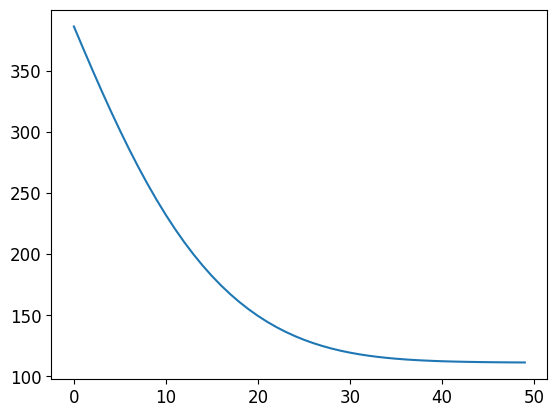

In [206]:
plt.plot(F_vals)
# plt.yscale("log")

In [227]:
def simplex_along_path(F, GD_path, grad_getter, jrandom_key):
    interp_points = None
    F_vals = None
    
    res = []
    m = 0
    res_coarse_grad = []
    for i in tqdm(range(len(GD_path))):
        jrandom_key, subkey = jrandom.split(jrandom_key)
        
        x_0 = GD_path[i]
        if (interp_points is not None) and (interp_points.shape[1] > 2 * len(x_0) + 1):
            H, rbf_f1 = F.f2(x_0), F.f1(x_0) # None 
#             curr_rbf = RBF(interp_points, F_vals, smoothing=0)
#             H, rbf_f1 = curr_rbf.f2(x_0), curr_rbf.f1(x_0) # get_H_rbf(x_0, interp_points[:, -50*50:], F_vals[-50*50:], smoothing=1)
#             print(jnp.linalg.norm(H - F.f2(x_0))/jnp.linalg.norm(F.f2(x_0)))
            m = max(m, abs(jnp.linalg.cond(H)))

        else:
            H, rbf_f1 = jnp.eye(len(x_0)), jnp.ones(len(x_0))
            
        res_coarse_grad.append(rbf_f1)
        
        grad_curr, _, F_x_0, FS, S = grad_getter.grad(F, x_0, subkey, H=H)
        res.append(grad_curr)
        
        if interp_points is None:
            interp_points = jnp.concatenate([S + x_0.reshape(-1, 1), x_0.reshape(-1, 1)], axis=1)
            F_vals = jnp.concatenate([FS, jnp.array([F_x_0])])
        else:
            interp_points = jnp.concatenate([interp_points, S + x_0.reshape(-1, 1), x_0.reshape(-1, 1)], axis=1)
            F_vals = jnp.concatenate([F_vals, FS, jnp.array([F_x_0])])
            
    return res, res_coarse_grad, interp_points
        
            

In [224]:
import pickle

In [230]:


res = {"ours": {}, "FD": {}, "CFD": {}}

hs = [0.05]
jrandom_key = jrandom.PRNGKey(0)

num_trials = 10

for h in hs:
    h = float(h)
    if h not in res["ours"]:
        res["ours"][h] = []
        res["FD"][h] = []
        res["CFD"][h] = []
        
    grad_getter_ours = Ours(sig, max_h=h)
    grad_getter_fd = FD(sig, is_central=False, h=h, use_H=True)
    grad_getter_cfg = FD(sig, is_central=True, h=h, use_H=False)

    for _ in range(num_trials):
        jrandom_key, subkey = jrandom.split(jrandom_key)

        res["ours"][h].append(simplex_along_path(F, path, grad_getter_ours, subkey))
        res["FD"][h].append(simplex_along_path(F, path, grad_getter_fd, subkey))
#         res["CFD"][h].append(simplex_along_path(F, path, grad_getter_fd, jrandom_key))

100%|███████████████████████████████████████████| 51/51 [00:01<00:00, 35.02it/s]


In [236]:
with open("data_opt_path_exact_H.pkl", "rb") as f:
    res_exact = pickle.load(f)
    
with open("data_opt_path.pkl", "rb") as f:
    res = pickle.load(f)

In [246]:
errs_all = {"ours": {}, "FD": {}, "CFD": {}}

for i in range(len(path)):
    for k in res:
        for h in res[k]:
            if h not in errs_all[k]:
                errs_all[k][h] = [[] for _ in range(len(res[k][h]))]
            for j in range(len(res[k][h])):
                    
                sg_err = jnp.linalg.norm(res[k][h][j][0][i] - F.f1(path[i]))
                coarse_err = jnp.linalg.norm(res[k][h][j][1][i] - F.f1(path[i]))
                errs_all[k][h][j].append([sg_err, coarse_err])



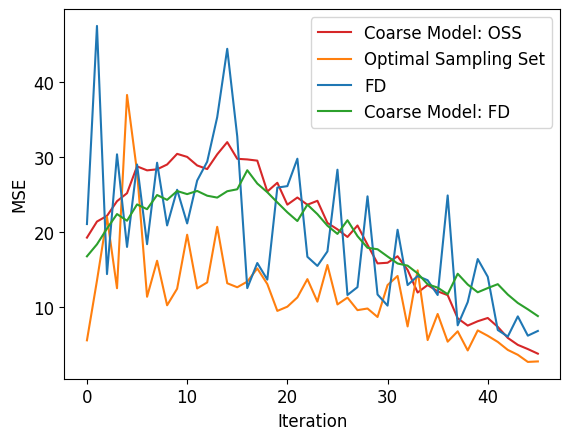

In [249]:

for k in ["ours", "FD"]:
    if k == "CFD":
        continue
    for h in errs_all[k]:
        curr_errs = jnp.mean(jnp.array(errs_all[k][h]), axis=0)
        if k== "ours":
            plt.plot(curr_errs[5:, 1], label="Coarse Model: OSS".format(k, h), color="C3")
            plt.plot(curr_errs[5:, 0], label="Optimal Sampling Set".format(k, h), color="C1")
        else:
            plt.plot(curr_errs[5:, 0], label="FD".format(k, h), color="C0")
            plt.plot(curr_errs[5:, 1], label="Coarse Model: FD".format(k, h), color="C2")


# plt.ylim(0, 1)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()

plt.savefig("gd_coarse", dpi=500)

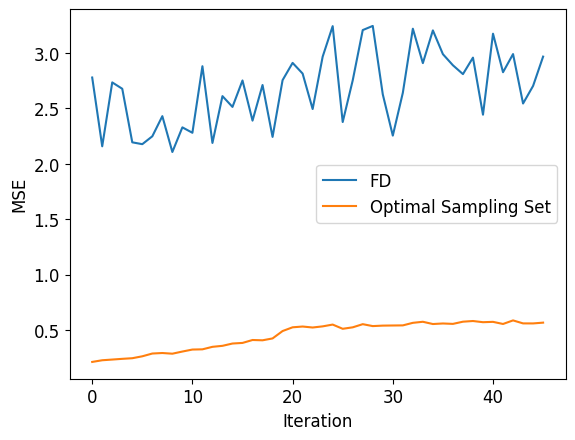

In [244]:

errs_all = {"ours": {}, "FD": {}, "CFD": {}}

for i in range(len(path)):
    for k in res_exact:
        for h in res_exact[k]:
            if h not in errs_all[k]:
                errs_all[k][h] = [[] for _ in range(len(res_exact[k][h]))]
            for j in range(len(res_exact[k][h])):
                    
                sg_err = jnp.linalg.norm(res_exact[k][h][j][0][i] - F.f1(path[i]))
                coarse_err = jnp.linalg.norm(res_exact[k][h][j][1][i] - F.f1(path[i]))
                errs_all[k][h][j].append([sg_err, coarse_err])




for k in ["FD", "ours"]:
    if k == "CFD":
        continue
    for h in errs_all[k]:
        curr_errs = jnp.mean(jnp.array(errs_all[k][h]), axis=0)
        if k == "ours":
            plt.plot(curr_errs[5:, 0], label="Optimal Sampling Set".format(k, h))
        else:
            plt.plot(curr_errs[5:, 0], label="FD".format(k, h))


# plt.ylim(0, 1)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()

plt.savefig("gd_exact", dpi=500)

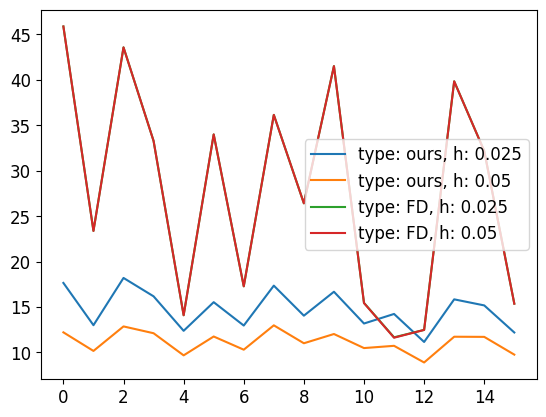

In [45]:

for k in errs_all:
#     if k != "CFD":
#         continue
    for h in errs_all[k]:
        curr_errs = jnp.array(errs_all[k][h])
        plt.plot(curr_errs[10:, 0], label="type: {}, h: {}".format(k, h))
#         plt.plot(curr_errs[10:, 1], label="Coarse type: {}, h: {}".format(k, h))


# plt.ylim(0, 1)
plt.legend()